In [8]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import Grid
from IPython.display import SVG
%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error

'''Algos'''
import lightgbm as lgb

'''TensorFlow and Keras'''
import tensorflow as tf
from tensorflow import keras
K = keras.backend

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, Lambda
from tensorflow.keras.layers import Embedding, Flatten, dot
from tensorflow.keras.layers import Conv2D, MaxPool2D, LeakyReLU, Reshape
from tensorflow.keras.layers import UpSampling2D, Conv2DTranspose
from tensorflow.keras import regularizers
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop

In [9]:
import sys, sklearn
print(f'sklearn    {sklearn.__version__}')
print(f'tensorflow {tf.__version__}')
print(f'keras      {keras.__version__}')
print(f'numpy      {np.__version__}')

sklearn    1.0.2
tensorflow 2.8.0
keras      2.8.0
numpy      1.21.6


In [10]:
tf.random.set_seed(42)
np.random.seed(42)

In [11]:
if tf.test.gpu_device_name():
    print('Default GPU Device : {}'.format(tf.test.gpu_device_name()))
else:
    print('Please install GPU version of TF, if GPU is available.')

Metal device set to: Apple M1
Default GPU Device : /device:GPU:0


2022-05-31 15:49:58.181550: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-31 15:49:58.184214: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-05-31 15:49:58.192603: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-31 15:49:58.192641: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)
X_train = X_train.reshape(48000,-1)
X_validation = X_validation.reshape(12000,-1)
X_test = X_test.reshape(10000,-1)

11501568/11490434 [==============================] - 1s 0us/step


In [13]:
# Reshape for TensorFlow
X_train_keras = X_train.reshape(48000,28,28,1)
X_validation_keras = X_validation.reshape(12000,28,28,1)
X_test_keras = X_test.reshape(10000,28,28,1)

y_train_keras = to_categorical(y_train)
y_validation_keras = to_categorical(y_validation)
y_test_keras = to_categorical(y_test)

In [14]:
# Create Pandas DataFrames from the datasets
train_index = range(0,len(X_train))
validation_index = range(len(X_train),len(X_train)+len(X_validation))
test_index = range(len(X_train)+len(X_validation),len(X_train)+ len(X_validation)+len(X_test))

X_train = pd.DataFrame(data=X_train,index=train_index)
y_train = pd.Series(data=y_train,index=train_index)

X_validation = pd.DataFrame(data=X_validation,index=validation_index)
y_validation = pd.Series(data=y_validation,index=validation_index)

X_test = pd.DataFrame(data=X_test,index=test_index)
y_test = pd.Series(data=y_test,index=test_index)

In [15]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same',
                 activation='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same',
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same',
                 activation='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same',
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

2022-05-31 15:50:29.959024: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-31 15:50:29.959097: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [16]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

cnn_history = model.fit(X_train_keras, y_train_keras,
                        validation_data=(X_validation_keras, y_validation_keras), epochs=100)

Epoch 1/100


2022-05-31 15:50:39.559427: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-31 15:50:39.923264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1499/1500 [============================>.] - ETA: 0s - loss: 0.2581 - accuracy: 0.9278

2022-05-31 15:51:00.705006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1500/1500 [==============================] - 24s 14ms/step - loss: 0.2581 - accuracy: 0.9279 - val_loss: 0.0704 - val_accuracy: 0.9790
Epoch 2/100
1500/1500 [==============================] - 21s 14ms/step - loss: 0.0962 - accuracy: 0.9715 - val_loss: 0.0512 - val_accuracy: 0.9846
Epoch 3/100
1500/1500 [==============================] - 22s 14ms/step - loss: 0.0837 - accuracy: 0.9751 - val_loss: 0.0447 - val_accuracy: 0.9851
Epoch 4/100
1500/1500 [==============================] - 21s 14ms/step - loss: 0.0782 - accuracy: 0.9771 - val_loss: 0.0470 - val_accuracy: 0.9852
Epoch 5/100
1500/1500 [==============================] - 21s 14ms/step - loss: 0.0712 - accuracy: 0.9794 - val_loss: 0.0707 - val_accuracy: 0.9803
Epoch 6/100
1500/1500 [==============================] - 21s 14ms/step - loss: 0.0670 - accuracy: 0.9807 - val_loss: 0.0441 - val_accuracy: 0.9868
Epoch 7/100
1500/1500 [==============================] - 21s 14ms/step - loss: 0.0677 - accuracy: 0.9811 - val_loss: 0.0529 - val_

1500/1500 [==============================] - 23s 15ms/step - loss: 0.0610 - accuracy: 0.9860 - val_loss: 0.0613 - val_accuracy: 0.9882
Epoch 57/100
1500/1500 [==============================] - 26s 17ms/step - loss: 0.0606 - accuracy: 0.9855 - val_loss: 0.0562 - val_accuracy: 0.9898
Epoch 58/100
1500/1500 [==============================] - 25s 17ms/step - loss: 0.0585 - accuracy: 0.9859 - val_loss: 0.0624 - val_accuracy: 0.9893
Epoch 59/100
1500/1500 [==============================] - 25s 17ms/step - loss: 0.0573 - accuracy: 0.9864 - val_loss: 0.0534 - val_accuracy: 0.9893
Epoch 60/100
1500/1500 [==============================] - 23s 15ms/step - loss: 0.0599 - accuracy: 0.9850 - val_loss: 0.0491 - val_accuracy: 0.9889
Epoch 61/100
1500/1500 [==============================] - 24s 16ms/step - loss: 0.0596 - accuracy: 0.9861 - val_loss: 0.0847 - val_accuracy: 0.9869
Epoch 62/100
1500/1500 [==============================] - 22s 15ms/step - loss: 0.0594 - accuracy: 0.9863 - val_loss: 0.0542 

CNN Final Accuracy 0.9871041774749756


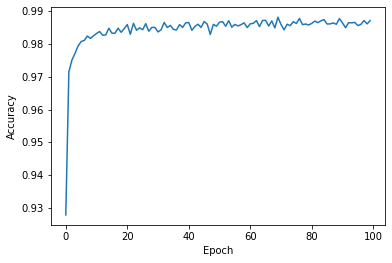

In [17]:
# Plot Accuract of CNN
print('CNN Final Accuracy', cnn_history.history['accuracy'][-1])
pd.Series(cnn_history.history['accuracy']).plot(logy=False)
plt.xlabel('Epoch')
plt.ylabel("Accuracy")
plt.show()

In [18]:
class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time))

class DCGAN(object):
    def __init__(self, img_rows=28, img_cols=28, channel=1):

        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channel = channel
        self.D = None   # discriminator
        self.G = None   # generator
        self.AM = None  # adversarial model
        self.DM = None  # discriminator model
        
    def generator(self, depth=256, dim=7, dropout=0.3, momentum=0.8, \
                  window=5, input_dim=100, output_depth=1):
        if self.G:
            return self.G
        self.G = Sequential()
        self.G.add(Dense(dim*dim*depth, input_dim=input_dim))
        self.G.add(BatchNormalization(momentum=momentum))
        self.G.add(Activation('relu'))
        self.G.add(Reshape((dim, dim, depth)))
        self.G.add(Dropout(dropout))
        
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/2), window, padding='same'))
        self.G.add(BatchNormalization(momentum=momentum))
        self.G.add(Activation('relu'))

        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/4), window, padding='same'))
        self.G.add(BatchNormalization(momentum=momentum))
        self.G.add(Activation('relu'))

        self.G.add(Conv2DTranspose(int(depth/8), window, padding='same'))
        self.G.add(BatchNormalization(momentum=momentum))
        self.G.add(Activation('relu'))

        self.G.add(Conv2DTranspose(output_depth, window, padding='same'))
        self.G.add(Activation('sigmoid'))
        self.G.summary()
        return self.G

    def discriminator(self, depth=64, dropout=0.3, alpha=0.3):
        if self.D:
            return self.D
        self.D = Sequential()
        input_shape = (self.img_rows, self.img_cols, self.channel)
        self.D.add(Conv2D(depth*1, 5, strides=2, input_shape=input_shape,
            padding='same'))
        self.D.add(LeakyReLU(alpha=alpha))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*2, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=alpha))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*4, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=alpha))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*8, 5, strides=1, padding='same'))
        self.D.add(LeakyReLU(alpha=alpha))
        self.D.add(Dropout(dropout))

        self.D.add(Flatten())
        self.D.add(Dense(1))
        self.D.add(Activation('sigmoid'))
        self.D.summary()
        return self.D

    def discriminator_model(self):
        if self.DM:
            return self.DM
        optimizer = RMSprop(lr=0.0002, decay=6e-8)
        self.DM = Sequential()
        self.DM.add(self.discriminator())
        self.DM.compile(loss='binary_crossentropy', \
                        optimizer=optimizer, metrics=['accuracy'])
        return self.DM

    def adversarial_model(self):
        if self.AM:
            return self.AM
        optimizer = RMSprop(lr=0.0001, decay=3e-8)
        self.AM = Sequential()
        self.AM.add(self.generator())
        self.AM.add(self.discriminator())
        self.AM.compile(loss='binary_crossentropy', \
                        optimizer=optimizer, metrics=['accuracy'])
        return self.AM
        
class MNIST_DCGAN(object):
    def __init__(self, x_train):
        self.img_rows = 28
        self.img_cols = 28
        self.channel = 1

        self.x_train = x_train

        self.DCGAN = DCGAN()
        self.discriminator =  self.DCGAN.discriminator_model()
        self.adversarial = self.DCGAN.adversarial_model()
        self.generator = self.DCGAN.generator()

    def train(self, train_steps=2000, batch_size=256, save_interval=0):
        noise_input = None
        if save_interval>0:
            noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
        for i in range(train_steps):
            images_train = self.x_train[np.random.randint(0,
                self.x_train.shape[0], size=batch_size), :, :, :]
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            images_fake = self.generator.predict(noise)
            x = np.concatenate((images_train, images_fake))
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            
            d_loss = self.discriminator.train_on_batch(x, y)

            y = np.ones([batch_size, 1])
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            a_loss = self.adversarial.train_on_batch(noise, y)
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], \
                                                      a_loss[1])
            print(log_mesg)
            if save_interval>0:
                if (i+1)%save_interval==0:
                    self.plot_images(save2file=True, \
                        samples=noise_input.shape[0],\
                        noise=noise_input, step=(i+1))

    def plot_images(self, save2file=False, fake=True, samples=16, \
                    noise=None, step=0):
        current_path = os.getcwd()
        file = os.path.sep.join(['', 'images', 'chapter12', 'synthetic_mnist', ''])
        filename = 'mnist.png'
        if fake:
            if noise is None:
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
            else:
                filename = "mnist_%d.png" % step
            images = self.generator.predict(noise)
        else:
            i = np.random.randint(0, self.x_train.shape[0], samples)
            images = self.x_train[i, :, :, :]

        plt.figure(figsize=(10,10))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.img_rows, self.img_cols])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        if save2file:
            plt.savefig(current_path+file+filename)
            plt.close('all')
        else:
            plt.show()

In [29]:
# Initialize MNIST DCGAN and train
mnist_dcgan = MNIST_DCGAN(X_train_keras)
timer = ElapsedTimer()
mnist_dcgan.train(train_steps=, batch_size=256, save_interval=0)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_23 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_24 (Dropout)        (None, 7, 7, 128)         0         
                                                                 
 conv2d_22 (Conv2D)          (None, 4, 4, 256)       

2022-05-31 19:59:31.070927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-31 19:59:31.597496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-31 19:59:33.261938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


0: [D loss: 1.186396, acc: 0.507812]  [A loss: 0.201920, acc: 1.000000]
1: [D loss: 2.603294, acc: 0.500000]  [A loss: 0.102659, acc: 1.000000]
2: [D loss: 1.528350, acc: 0.500000]  [A loss: 0.077793, acc: 1.000000]
3: [D loss: 1.178800, acc: 0.500000]  [A loss: 0.057673, acc: 1.000000]
4: [D loss: 0.953754, acc: 0.500000]  [A loss: 0.043085, acc: 1.000000]
5: [D loss: 0.790659, acc: 0.500000]  [A loss: 0.031167, acc: 1.000000]
6: [D loss: 0.677558, acc: 0.500000]  [A loss: 0.022993, acc: 1.000000]
7: [D loss: 0.596771, acc: 0.500000]  [A loss: 0.016985, acc: 1.000000]
8: [D loss: 0.544484, acc: 0.500000]  [A loss: 0.013805, acc: 1.000000]
9: [D loss: 0.509141, acc: 0.500000]  [A loss: 0.011165, acc: 1.000000]
10: [D loss: 0.484467, acc: 0.500000]  [A loss: 0.009745, acc: 1.000000]
11: [D loss: 0.468446, acc: 0.500000]  [A loss: 0.008680, acc: 1.000000]
12: [D loss: 0.461466, acc: 0.500000]  [A loss: 0.008204, acc: 1.000000]
13: [D loss: 0.460208, acc: 0.500000]  [A loss: 0.008300, acc

113: [D loss: 0.129032, acc: 0.996094]  [A loss: 0.040070, acc: 1.000000]
114: [D loss: 0.159194, acc: 0.978516]  [A loss: 0.290920, acc: 1.000000]
115: [D loss: 0.212441, acc: 0.935547]  [A loss: 0.406917, acc: 0.894531]
116: [D loss: 0.186546, acc: 0.964844]  [A loss: 0.297561, acc: 1.000000]
117: [D loss: 0.595504, acc: 0.992188]  [A loss: 0.000269, acc: 1.000000]
118: [D loss: 1.862353, acc: 0.500000]  [A loss: 0.236181, acc: 1.000000]
119: [D loss: 0.233647, acc: 0.943359]  [A loss: 0.139354, acc: 1.000000]
120: [D loss: 0.177349, acc: 0.982422]  [A loss: 0.133123, acc: 1.000000]
121: [D loss: 0.160581, acc: 0.986328]  [A loss: 0.134355, acc: 1.000000]
122: [D loss: 0.151016, acc: 0.986328]  [A loss: 0.137776, acc: 1.000000]
123: [D loss: 0.153179, acc: 0.984375]  [A loss: 0.154707, acc: 1.000000]
124: [D loss: 0.170170, acc: 0.970703]  [A loss: 0.191767, acc: 1.000000]
125: [D loss: 0.224389, acc: 0.927734]  [A loss: 0.311056, acc: 0.972656]
126: [D loss: 0.304255, acc: 0.814453]

224: [D loss: 0.004384, acc: 1.000000]  [A loss: 0.011017, acc: 1.000000]
225: [D loss: 0.004344, acc: 1.000000]  [A loss: 0.010621, acc: 1.000000]
226: [D loss: 0.004492, acc: 1.000000]  [A loss: 0.012265, acc: 1.000000]
227: [D loss: 0.005965, acc: 1.000000]  [A loss: 0.022615, acc: 1.000000]
228: [D loss: 0.026014, acc: 1.000000]  [A loss: 4.994256, acc: 0.000000]
229: [D loss: 0.659246, acc: 0.632812]  [A loss: 15.392780, acc: 0.000000]
230: [D loss: 29.410172, acc: 0.841797]  [A loss: 0.000000, acc: 1.000000]
231: [D loss: 4.701394, acc: 0.500000]  [A loss: 0.000002, acc: 1.000000]
232: [D loss: 3.691862, acc: 0.500000]  [A loss: 0.000015, acc: 1.000000]
233: [D loss: 2.770889, acc: 0.500000]  [A loss: 0.000122, acc: 1.000000]
234: [D loss: 1.883245, acc: 0.500000]  [A loss: 0.000830, acc: 1.000000]
235: [D loss: 1.076423, acc: 0.501953]  [A loss: 0.004768, acc: 1.000000]
236: [D loss: 0.558383, acc: 0.591797]  [A loss: 0.014393, acc: 1.000000]
237: [D loss: 0.340964, acc: 0.80273

335: [D loss: 0.002368, acc: 1.000000]  [A loss: 0.004574, acc: 1.000000]
336: [D loss: 0.002357, acc: 1.000000]  [A loss: 0.004288, acc: 1.000000]
337: [D loss: 0.002164, acc: 1.000000]  [A loss: 0.004032, acc: 1.000000]
338: [D loss: 0.002166, acc: 1.000000]  [A loss: 0.003479, acc: 1.000000]
339: [D loss: 0.001955, acc: 1.000000]  [A loss: 0.003532, acc: 1.000000]
340: [D loss: 0.001841, acc: 1.000000]  [A loss: 0.003351, acc: 1.000000]
341: [D loss: 0.001714, acc: 1.000000]  [A loss: 0.003106, acc: 1.000000]
342: [D loss: 0.001621, acc: 1.000000]  [A loss: 0.002851, acc: 1.000000]
343: [D loss: 0.001778, acc: 1.000000]  [A loss: 0.002851, acc: 1.000000]
344: [D loss: 0.001531, acc: 1.000000]  [A loss: 0.002700, acc: 1.000000]
345: [D loss: 0.001440, acc: 1.000000]  [A loss: 0.002579, acc: 1.000000]
346: [D loss: 0.001365, acc: 1.000000]  [A loss: 0.002375, acc: 1.000000]
347: [D loss: 0.001353, acc: 1.000000]  [A loss: 0.002207, acc: 1.000000]
348: [D loss: 0.001285, acc: 1.000000]

446: [D loss: 0.000157, acc: 1.000000]  [A loss: 0.000399, acc: 1.000000]
447: [D loss: 0.000138, acc: 1.000000]  [A loss: 0.000444, acc: 1.000000]
448: [D loss: 0.000121, acc: 1.000000]  [A loss: 0.000471, acc: 1.000000]
449: [D loss: 0.000143, acc: 1.000000]  [A loss: 0.000421, acc: 1.000000]
450: [D loss: 0.000133, acc: 1.000000]  [A loss: 0.000517, acc: 1.000000]
451: [D loss: 0.000186, acc: 1.000000]  [A loss: 0.000361, acc: 1.000000]
452: [D loss: 0.000166, acc: 1.000000]  [A loss: 0.000482, acc: 1.000000]
453: [D loss: 0.000181, acc: 1.000000]  [A loss: 0.000527, acc: 1.000000]
454: [D loss: 0.000131, acc: 1.000000]  [A loss: 0.000437, acc: 1.000000]
455: [D loss: 0.000167, acc: 1.000000]  [A loss: 0.000410, acc: 1.000000]
456: [D loss: 0.000118, acc: 1.000000]  [A loss: 0.000447, acc: 1.000000]
457: [D loss: 0.000122, acc: 1.000000]  [A loss: 0.000429, acc: 1.000000]
458: [D loss: 0.000115, acc: 1.000000]  [A loss: 0.000423, acc: 1.000000]
459: [D loss: 0.000125, acc: 1.000000]

557: [D loss: 0.000080, acc: 1.000000]  [A loss: 0.000034, acc: 1.000000]
558: [D loss: 0.000123, acc: 1.000000]  [A loss: 0.000034, acc: 1.000000]
559: [D loss: 0.000066, acc: 1.000000]  [A loss: 0.000041, acc: 1.000000]
560: [D loss: 0.000083, acc: 1.000000]  [A loss: 0.000039, acc: 1.000000]
561: [D loss: 0.000063, acc: 1.000000]  [A loss: 0.000069, acc: 1.000000]
562: [D loss: 0.000073, acc: 1.000000]  [A loss: 0.000041, acc: 1.000000]
563: [D loss: 0.000083, acc: 1.000000]  [A loss: 0.000066, acc: 1.000000]
564: [D loss: 0.000051, acc: 1.000000]  [A loss: 0.000076, acc: 1.000000]
565: [D loss: 0.000042, acc: 1.000000]  [A loss: 0.000066, acc: 1.000000]
566: [D loss: 0.000060, acc: 1.000000]  [A loss: 0.000057, acc: 1.000000]
567: [D loss: 0.000064, acc: 1.000000]  [A loss: 0.000067, acc: 1.000000]
568: [D loss: 0.000036, acc: 1.000000]  [A loss: 0.000084, acc: 1.000000]
569: [D loss: 0.000039, acc: 1.000000]  [A loss: 0.000058, acc: 1.000000]
570: [D loss: 0.000049, acc: 1.000000]

668: [D loss: 0.777118, acc: 0.681641]  [A loss: 0.000002, acc: 1.000000]
669: [D loss: 0.189259, acc: 0.906250]  [A loss: 0.000001, acc: 1.000000]
670: [D loss: 0.101083, acc: 0.957031]  [A loss: 0.000002, acc: 1.000000]
671: [D loss: 0.068285, acc: 0.984375]  [A loss: 0.000025, acc: 1.000000]
672: [D loss: 0.044340, acc: 0.990234]  [A loss: 0.000016, acc: 1.000000]
673: [D loss: 0.036708, acc: 0.992188]  [A loss: 0.000016, acc: 1.000000]
674: [D loss: 0.022945, acc: 0.998047]  [A loss: 0.000041, acc: 1.000000]
675: [D loss: 0.026957, acc: 0.998047]  [A loss: 0.000051, acc: 1.000000]
676: [D loss: 0.019823, acc: 0.994141]  [A loss: 0.000018, acc: 1.000000]
677: [D loss: 0.014889, acc: 0.998047]  [A loss: 0.000085, acc: 1.000000]
678: [D loss: 0.013346, acc: 1.000000]  [A loss: 0.000037, acc: 1.000000]
679: [D loss: 0.013016, acc: 0.998047]  [A loss: 0.000041, acc: 1.000000]
680: [D loss: 0.012503, acc: 0.996094]  [A loss: 0.000043, acc: 1.000000]
681: [D loss: 0.008922, acc: 1.000000]

779: [D loss: 0.000143, acc: 1.000000]  [A loss: 0.000337, acc: 1.000000]
780: [D loss: 0.000109, acc: 1.000000]  [A loss: 0.000279, acc: 1.000000]
781: [D loss: 0.000146, acc: 1.000000]  [A loss: 0.000375, acc: 1.000000]
782: [D loss: 0.000118, acc: 1.000000]  [A loss: 0.000303, acc: 1.000000]
783: [D loss: 0.000120, acc: 1.000000]  [A loss: 0.000422, acc: 1.000000]
784: [D loss: 0.000128, acc: 1.000000]  [A loss: 0.000454, acc: 1.000000]
785: [D loss: 0.000114, acc: 1.000000]  [A loss: 0.000328, acc: 1.000000]
786: [D loss: 0.000112, acc: 1.000000]  [A loss: 0.000402, acc: 1.000000]
787: [D loss: 0.000123, acc: 1.000000]  [A loss: 0.000289, acc: 1.000000]
788: [D loss: 0.000136, acc: 1.000000]  [A loss: 0.000284, acc: 1.000000]
789: [D loss: 0.000120, acc: 1.000000]  [A loss: 0.000404, acc: 1.000000]
790: [D loss: 0.000141, acc: 1.000000]  [A loss: 0.000439, acc: 1.000000]
791: [D loss: 0.000118, acc: 1.000000]  [A loss: 0.000272, acc: 1.000000]
792: [D loss: 0.000101, acc: 1.000000]

890: [D loss: 0.000040, acc: 1.000000]  [A loss: 0.000386, acc: 1.000000]
891: [D loss: 0.000048, acc: 1.000000]  [A loss: 0.000528, acc: 1.000000]
892: [D loss: 0.000032, acc: 1.000000]  [A loss: 0.000713, acc: 1.000000]
893: [D loss: 0.000040, acc: 1.000000]  [A loss: 0.000483, acc: 1.000000]
894: [D loss: 0.000048, acc: 1.000000]  [A loss: 0.000581, acc: 1.000000]
895: [D loss: 0.000031, acc: 1.000000]  [A loss: 0.000559, acc: 1.000000]
896: [D loss: 0.000031, acc: 1.000000]  [A loss: 0.000418, acc: 1.000000]
897: [D loss: 0.000038, acc: 1.000000]  [A loss: 0.000405, acc: 1.000000]
898: [D loss: 0.000032, acc: 1.000000]  [A loss: 0.000354, acc: 1.000000]
899: [D loss: 0.000049, acc: 1.000000]  [A loss: 0.000360, acc: 1.000000]
900: [D loss: 0.000035, acc: 1.000000]  [A loss: 0.000477, acc: 1.000000]
901: [D loss: 0.000030, acc: 1.000000]  [A loss: 0.000361, acc: 1.000000]
902: [D loss: 0.000056, acc: 1.000000]  [A loss: 0.000376, acc: 1.000000]
903: [D loss: 0.000032, acc: 1.000000]

KeyboardInterrupt: 

Elapsed: 34.916632449626924 min 


2022-05-31 20:34:26.143946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


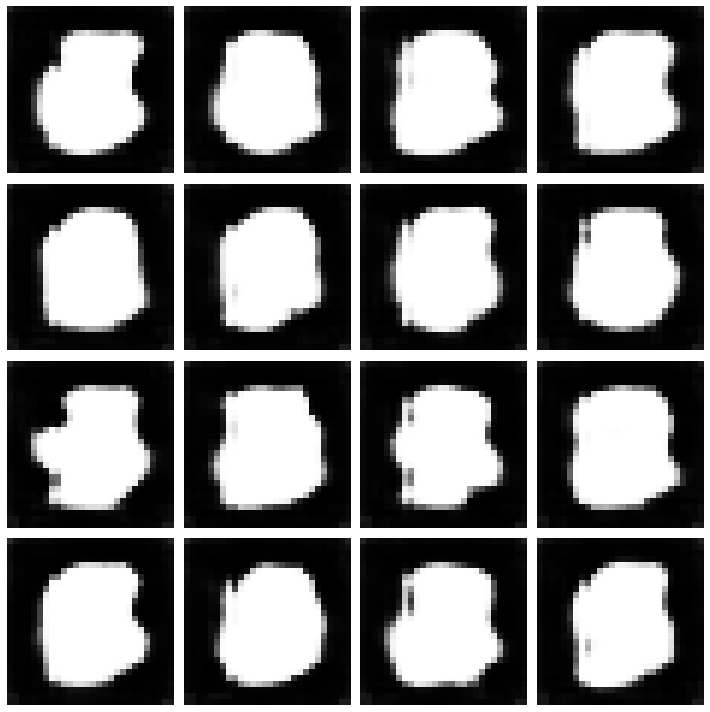

In [30]:
timer.elapsed_time()
mnist_dcgan.plot_images(fake=True)